# Multi-annotator Pool-based Active Learning - Getting Started

This Notebook gives an introduction for dealing with multiple annotators using `scikit-activeml`.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification

from skactiveml.classifier import PWC
from skactiveml.pool import UncertaintySampling
from skactiveml.pool.multi._wrapper import MultiAnnotWrapper
from skactiveml.utils import is_unlabeled, MISSING_LABEL, majority_vote
from skactiveml.visualization.multi._multi_annot_feature_space import plot_ma_current_state, plot_ma_data_set
warnings.filterwarnings('ignore')

Suppose we have the following problem. We have 50 samples having 2 features
belonging to one of two classes. To generate the example problem, we
use the `make_classification` function by sklearn.

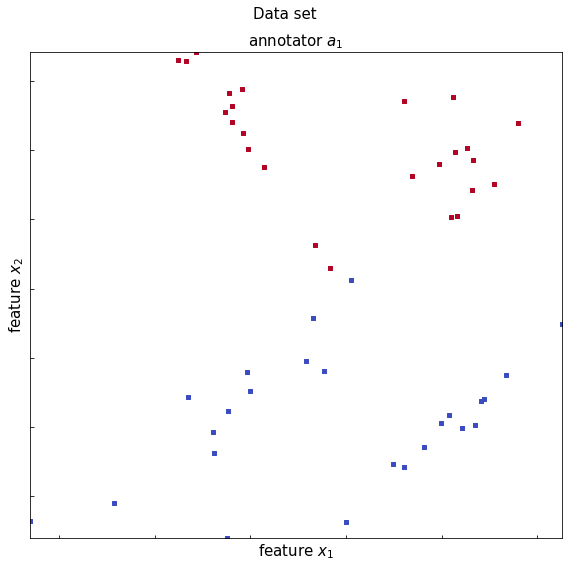

In [2]:
n_samples = 50
X, y_true = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, random_state=0)
fig = plot_ma_data_set(X, y_true.reshape(-1, 1), y_true, title='Data set', fig_size=(8, 8),
              plot_legend=False)
fig.tight_layout()
plt.show()

Further, suppose we have 5 annotators to label the samples. The annotators have
different accuracies for labeling the samples.

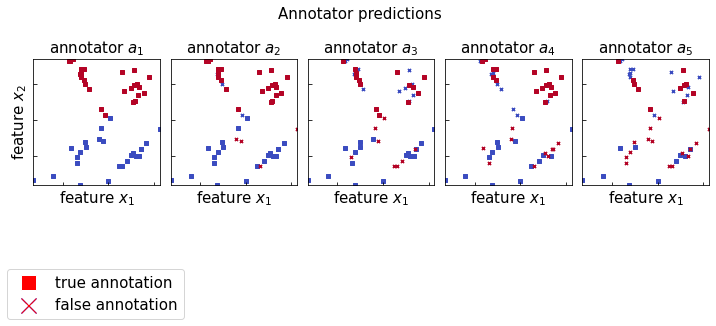

In [3]:
rng = np.random.default_rng(seed=0)
n_annotators = 5
y_annot = np.zeros(shape=(n_samples, n_annotators), dtype=int)
for i, p in enumerate(np.linspace(0.0, 0.5, num=n_annotators)):
    y_noise = rng.binomial(1, p, n_samples)
    y_annot[:, i] = y_noise ^ y_true

fig = plot_ma_data_set(X, y_annot, y_true, title='Annotator predictions', fig_size=(10, 3),
                       legend_dict={'loc': 'lower left'})
fig.tight_layout()
plt.show()

We want to label these samples using a Parzen window classifier. We query the
samples using uncertainty sampling, and the annotators at random using the
`MultiAnnotWrapper`.
To achieve this, we first pass the Parzen window classifier as an argument to
the single annotator query strategy uncertainty sampling. Then we pass the single annotator query
strategy as an argument to the wrapper, also specifying the number of annotators.


In [4]:
clf = PWC(classes=np.unique(y_true))
sa_qs = UncertaintySampling(random_state=0)
ma_qs = MultiAnnotWrapper(sa_qs, random_state=0, n_annotators=n_annotators)

We loop through the process of querying samples and annotators over a total of
20 cycles. Each iteration, we query three annotators for one sample, setting the
batch size and the number of annotators per sample to three.
We set the candidate annotators for each sample to be those, who have not already
labeled the given sample. Further we fit our classifier using the majority votes
of the queried labels.
The results are displayed after the 5th, the 14th, and the 20th cycle.
The assigned utilities of the query strategy for labeling a sample annotator
pair are displayed by the saturation of the green color in the plot.


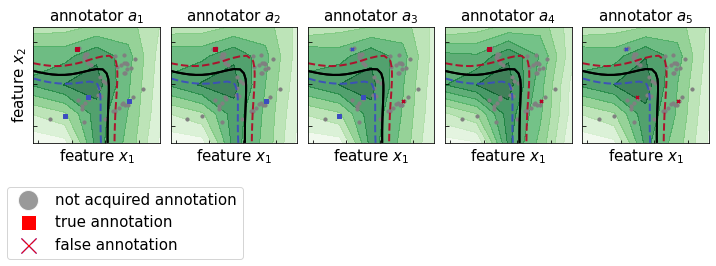

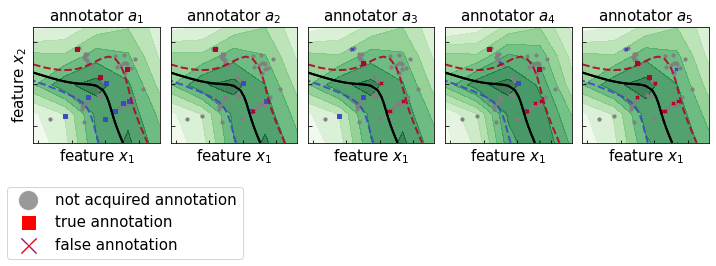

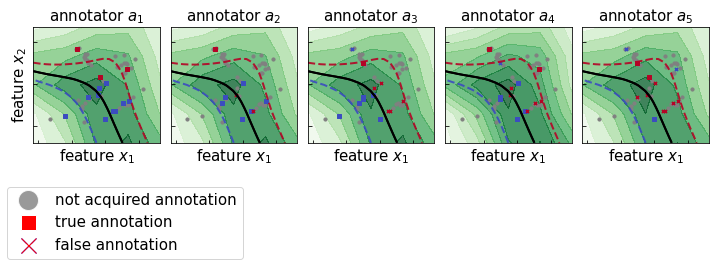

In [5]:
# function to be able to index via an array of indices
idx = lambda A: (A[:, 0], A[:, 1])

n_cycle = 20

# the already observed labels for each sample and annotator
y = np.full(shape=(n_samples, n_annotators), fill_value=MISSING_LABEL)
clf.fit(X, majority_vote(y))
for c in range(n_cycle):
    A_cand = is_unlabeled(y)

    # the needed query parameters for the wrapped singe annotator query strategy
    query_params_dict = {'clf': clf}

    query_idx = ma_qs.query(X_cand=X, A_cand=A_cand, batch_size=3,
                            n_annotators_per_sample=3,
                            query_params_dict=query_params_dict)

    y[idx(query_idx)] = y_annot[idx(query_idx)]
    clf.fit(X, majority_vote(y, random_state=0))
    if c in [4, 13, 19]:
        ma_qs_arg_dict = {'query_params_dict': query_params_dict}
        fig = plot_ma_current_state(X, y, y_true, ma_qs, clf, epsilon=1, ma_qs_arg_dict=ma_qs_arg_dict,
                                    fig_size=(10, 2.5))
        fig.tight_layout()
        plt.show()